In [2]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [18]:
def construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals, mapper_type='ParityMapper'):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo]) # ----------- Enter your code here

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = mapper_type

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True)# ----------- Enter your code here    

    # Compute the Hamitonian in qubit form
    qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
   
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=UCC(excitations='sd')) 
    solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op_parity, real_solution, problem_reduced## Converting to eV unit from Hartree unit

In [4]:
def custom_vqe(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job =  estimator.run(ansatz, ops, x).result()# ----------- Enter your code here
        results = job.values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result =  optimizer.minimize(evaluate_expectation, initial_point)# ----------- Enter your code here

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = MinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

In [5]:
def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(np.array(energy)*27.211, label="Estimator VQE {}".format(molecule),color = color) ## Converting to eV  unit from Hertree unit
    plt.axhline(y=real_solution.real*27.211, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [eV]")
    plt.title("VQE energy")
    plt.show()

In [6]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

The information about molecular structure could be accessible [here](https://webbook.nist.gov/cgi/cbook.cgi?Name=LiH&Units=SI).

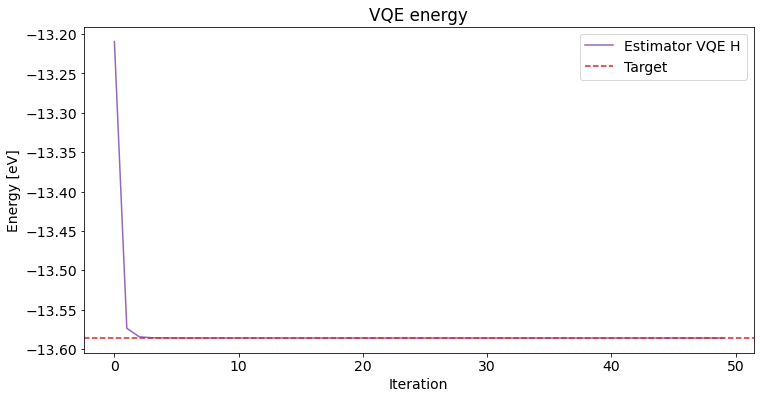

In [7]:
# Constructing H
hydrogen_a = [["H",[0.0,0.0,0.0]]] 

# For H
ansatz_a, ops_a, real_solution_a, problem_reduced_a = construct_problem(geometry=hydrogen_a, charge=0, multiplicity=2, basis="ccpvdz", num_electrons=(1,0), num_molecular_orbitals=2)

# Estimator VQE for H
Energy_H_a,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_a, ops=ops_a, problem_reduced=problem_reduced_a)


# Plot Graph H
plot_graph(Energy_H_a, real_solution_a, "H",color = "tab:purple")

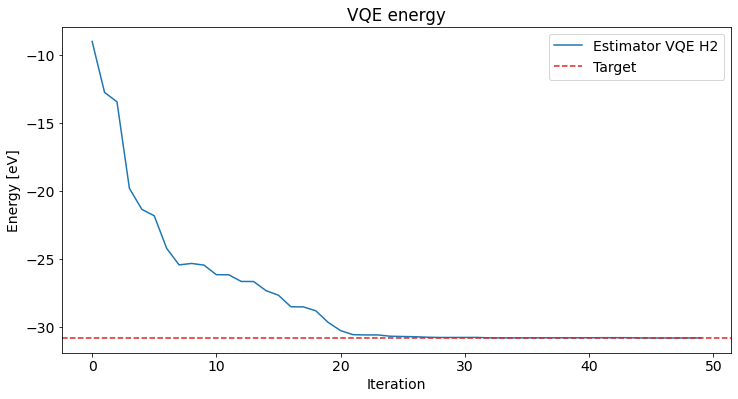

In [19]:
# Constructing H2
hydrogen_m = [["H", [0.3714,    0.0,    0.0]], 
              ["H",[ -0.3714,    0.0,   0.0]]] 

# For H2
ansatz_m, ops_m, real_solution_m, problem_reduced_m = construct_problem(geometry=hydrogen_m, charge=0, multiplicity=1, basis="ccpvdz", num_electrons=2,
                                                                        num_molecular_orbitals=2, mapper_type='JordanWignerMapper')

# Estimator VQE for H2
Energy_H_m,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

# Plot Graph H2
plot_graph(Energy_H_m, real_solution_m, "H2")

In [20]:
print(ops_m)

-1.1610319438813568 * IIII
+ 0.282007802501702 * IIIZ
- 0.003861706046516672 * IIZI
+ 0.282007802501702 * IZII
- 0.003861706046516672 * ZIII
+ 0.08210369988673771 * IIZZ
+ 0.16450096360683883 * IZIZ
+ 0.01406870823014119 * YYYY
+ 0.01406870823014119 * XXYY
+ 0.01406870823014119 * YYXX
+ 0.01406870823014119 * XXXX
+ 0.09617240811687891 * ZIIZ
+ 0.09617240811687891 * IZZI
+ 0.08368657135691446 * ZIZI
+ 0.08210369988673771 * ZZII


In [14]:
print(ops_m)

-1.325239343654831 * II
+ 0.28586950854821885 * IZ
- 0.28586950854821885 * ZI
- 0.05584271872999612 * ZZ
+ 0.05627483292056492 * XX


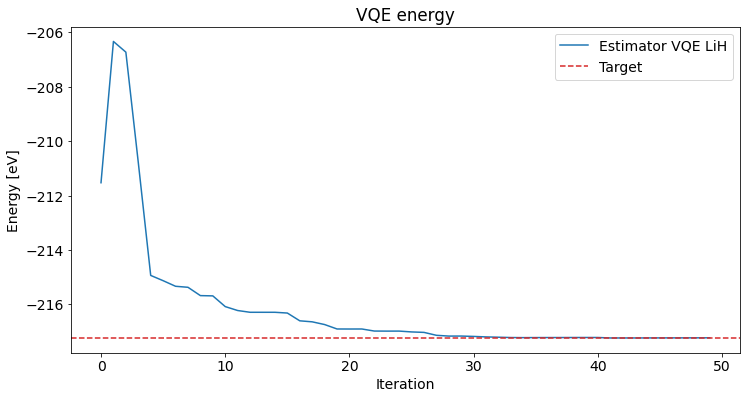

In [21]:
# Constructing LiH
Li_H = [['Li', [-0.0222,  0.0000,    0.0000]],
        ['H',    [1.5982,    0.0000,    0.0000]]]

# For LiH
ansatz_m, ops_m, real_solution_m, problem_reduced_m = construct_problem(geometry=Li_H, charge=0, multiplicity=1, basis="ccpvdz", num_electrons=2, num_molecular_orbitals=2)

# Estimator VQE for LiH
Energy_LiH_m,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

# Plot Graph LiH
plot_graph(Energy_LiH_m, real_solution_m, "LiH")

In [26]:
Energy_LiH_m[-1].real, real_solution_m.real ## In Hartree unit this is ground state energy of LiH

(-7.9830677018044245, -7.983772106798327)